In [1]:
from pathlib import Path
from typing import Iterable
import re

import pandas as pd
import plotnine as gg
import janitor


In [2]:
_ = gg.theme_set(
    gg.theme_classic()
    + gg.theme(axis_ticks=gg.element_blank(), strip_background=gg.element_blank(), panel_grid_major_y=gg.element_line())
)
%matplotlib inline
%config InlineBackend.figure_format='retina'

library_pal = {"pymc3": "#12698A", "stan": "#B2001D"}

In [3]:
project_root_dir = Path("..")
benchmarks_dir = project_root_dir / "benchmarks"
n_benchmarks = len(list(benchmarks_dir.iterdir()))
print(f"number of benchmarks: {n_benchmarks}")

model_size_csv = project_root_dir / "model-result-file-sizes.csv"
assert model_size_csv.is_file() and model_size_csv.exists()


number of benchmarks: 640


| colname   |   type (unit)   | description                                                                                                                                                                         |
|-----------|:---------------:|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| s         | float (seconds) | Running time in seconds                                                                                                                                                             |
| h:m:s     |    string (-)   | Running time in hour, minutes, seconds format                                                                                                                                       |
| max_rss   |    float (MB)   | Maximum "Resident Set Size”, this is the non-swapped physical memory a process has used.                                                                                            |
| max_vms   |    float (MB)   | Maximum “Virtual Memory Size”, this is the total amount of virtual memory used by the process                                                                                       |
| max_uss   |    float (MB)   | “Unique Set Size”, this is the memory which is unique to a process and which would be freed if the process was terminated right now.                                                |
| max_pss   |    float (MB)   | “Proportional Set Size”, is the amount of memory shared with other processes, accounted in a way that the amount is divided evenly between the processes that share it (Linux only) |
| io_in     |    float (MB)   | the number of MB read (cumulative).                                                                                                                                                 |
| io_out    |    float (MB)   | the number of MB written (cumulative).                                                                                                                                              |
| mean_load |    float (-)    | CPU usage over time, divided by the total running time (first row)                                                                                                                  |
| cpu_time  |     float(-)    | CPU time summed for user and system                                                                                                                                                 |

In [4]:
def read_benchmark(file: Path) -> pd.DataFrame:
    return pd.read_table(file, sep="\t").assign(name=file.name.replace(file.suffix, ""))


def stan_or_pymc3(names: Iterable[str]) -> list[str]:
    return [re.findall("stan|pymc3", n)[0] for n in names]


def _fix_simple_model_names(names: Iterable[str]) -> list[str]:
    new_names: list[str] = []
    for name in names:
        new_names.append(
            name.replace("simple-pymc3-", "simple_pymc3_").replace(
                "simple-stan-", "simple_stan_"
            )
        )
    return new_names


def parse_model_names(df: pd.DataFrame, col: str = "name") -> pd.DataFrame:
    return df.assign(
        library=lambda d: stan_or_pymc3(d.name),
        model=lambda d: [x.split("_")[0].strip() for x in d.name],
        data_size=lambda d: [x.split("_")[2].strip() for x in d.name],
    )


benchmarks = (
    pd.concat(read_benchmark(f) for f in benchmarks_dir.iterdir())
    .assign(name=lambda d: _fix_simple_model_names(d.name))
    .reset_index(drop=True)
    .pipe(parse_model_names)
    .assign(time_minutes=lambda d: d.s / 60.0)
)
benchmarks.head()


,1.0312433242797852,name,s,h:m:s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,...,1.4753496646881104,194.7928237915039,84.81583309173584,7.695703983306885,5.002972602844238,209.12334084510803,library,model,data_size,time_minutes
0,0.928491,simple_stan_100__8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,stan,simple,100,NaN
1,0.928456,simple_stan_100__8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,stan,simple,100,NaN
2,0.945413,simple_stan_100__8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,stan,simple,100,NaN
3,0.941897,simple_stan_100__8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,stan,simple,100,NaN
4,NaN,hierarchical_stan_10-10-2__4,18.1102,0:00:18,708.04,3300.77,190.66,224.06,2.86,12.63,...,NaN,NaN,NaN,NaN,NaN,NaN,stan,hierarchical,10-10-2,0.301837


In [5]:
benchmark_metrics = [
    "time_minutes",
    "max_rss",
    "max_vms",
    "max_pss",
    "cpu_time",
    "mean_load",
]
benchmark_ids = ["name", "model", "library", "data_size"]

benchmarks_long = (
    benchmarks[benchmark_ids + benchmark_metrics]
    .pivot_longer(benchmark_ids)
    .query("value != '-'")
    .astype({"value": "float"})
)

benchmarks_long["variable"] = pd.Categorical(
    benchmarks_long["variable"], categories=benchmark_metrics, ordered=True
)

benchmarks_long.head()


,name,model,library,data_size,variable,value
0,simple_stan_100__8,simple,stan,100,time_minutes,NaN
1,simple_stan_100__8,simple,stan,100,time_minutes,NaN
2,simple_stan_100__8,simple,stan,100,time_minutes,NaN
3,simple_stan_100__8,simple,stan,100,time_minutes,NaN
4,hierarchical_stan_10-10-2__4,hierarchical,stan,10-10-2,time_minutes,0.301837


/n/data1/hms/dbmi/park/Cook/pymc3-stan-comparison/.snakemake/conda/1f1b47776dfc6e2c3fc707a52a2e4e7a/lib/python3.9/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 2400 rows containing non-finite values.
/n/data1/hms/dbmi/park/Cook/pymc3-stan-comparison/.snakemake/conda/1f1b47776dfc6e2c3fc707a52a2e4e7a/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_jitter : Removed 2400 rows containing missing values.


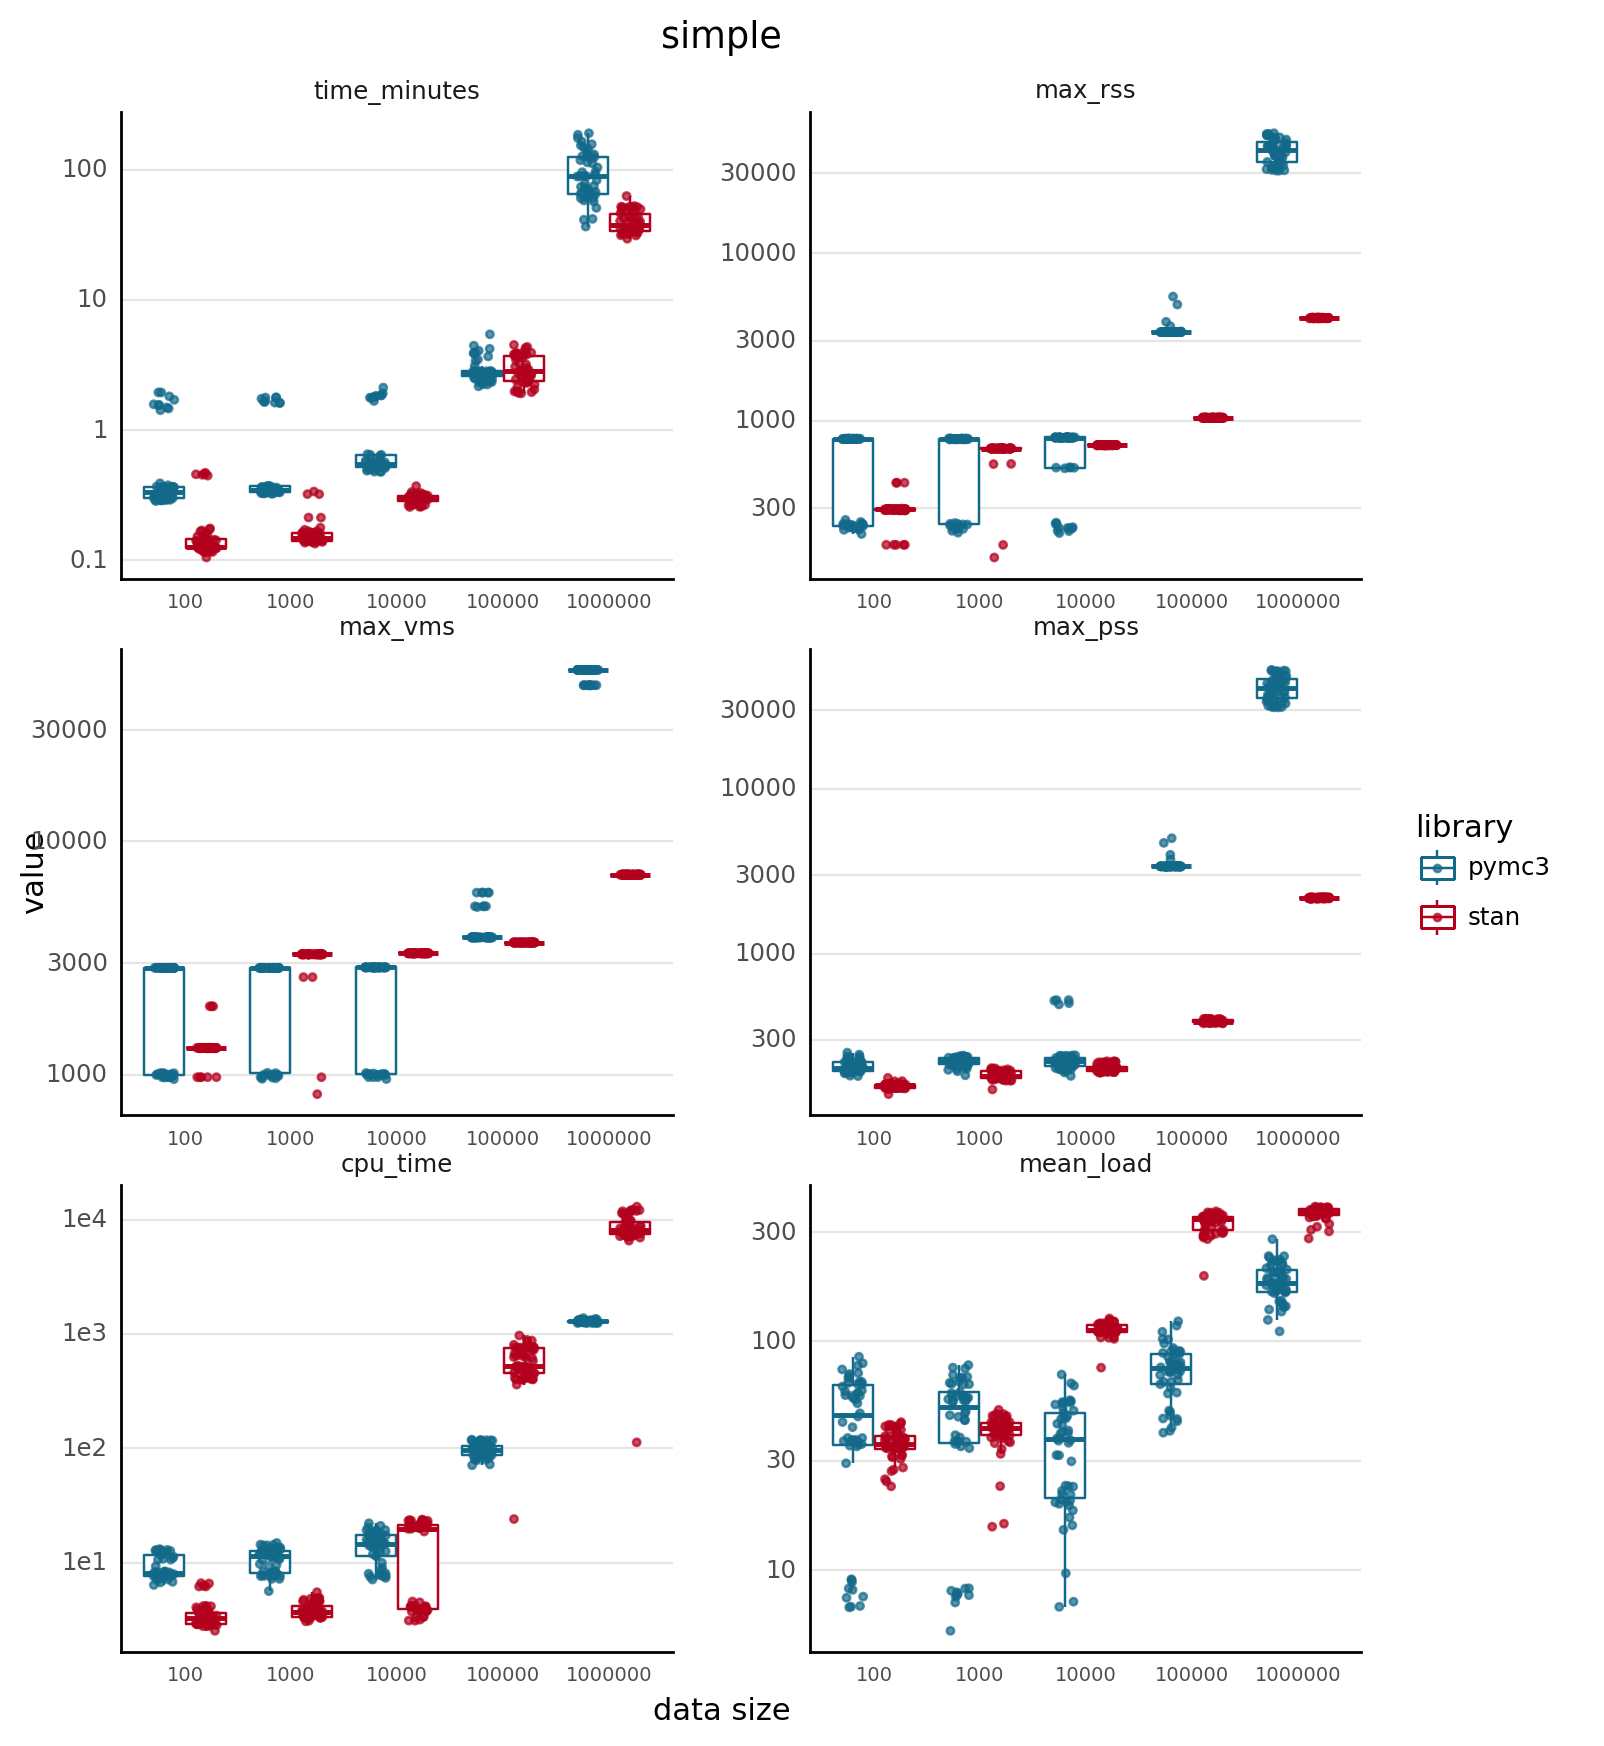

/n/data1/hms/dbmi/park/Cook/pymc3-stan-comparison/.snakemake/conda/1f1b47776dfc6e2c3fc707a52a2e4e7a/lib/python3.9/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 3360 rows containing non-finite values.
/n/data1/hms/dbmi/park/Cook/pymc3-stan-comparison/.snakemake/conda/1f1b47776dfc6e2c3fc707a52a2e4e7a/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_jitter : Removed 3360 rows containing missing values.


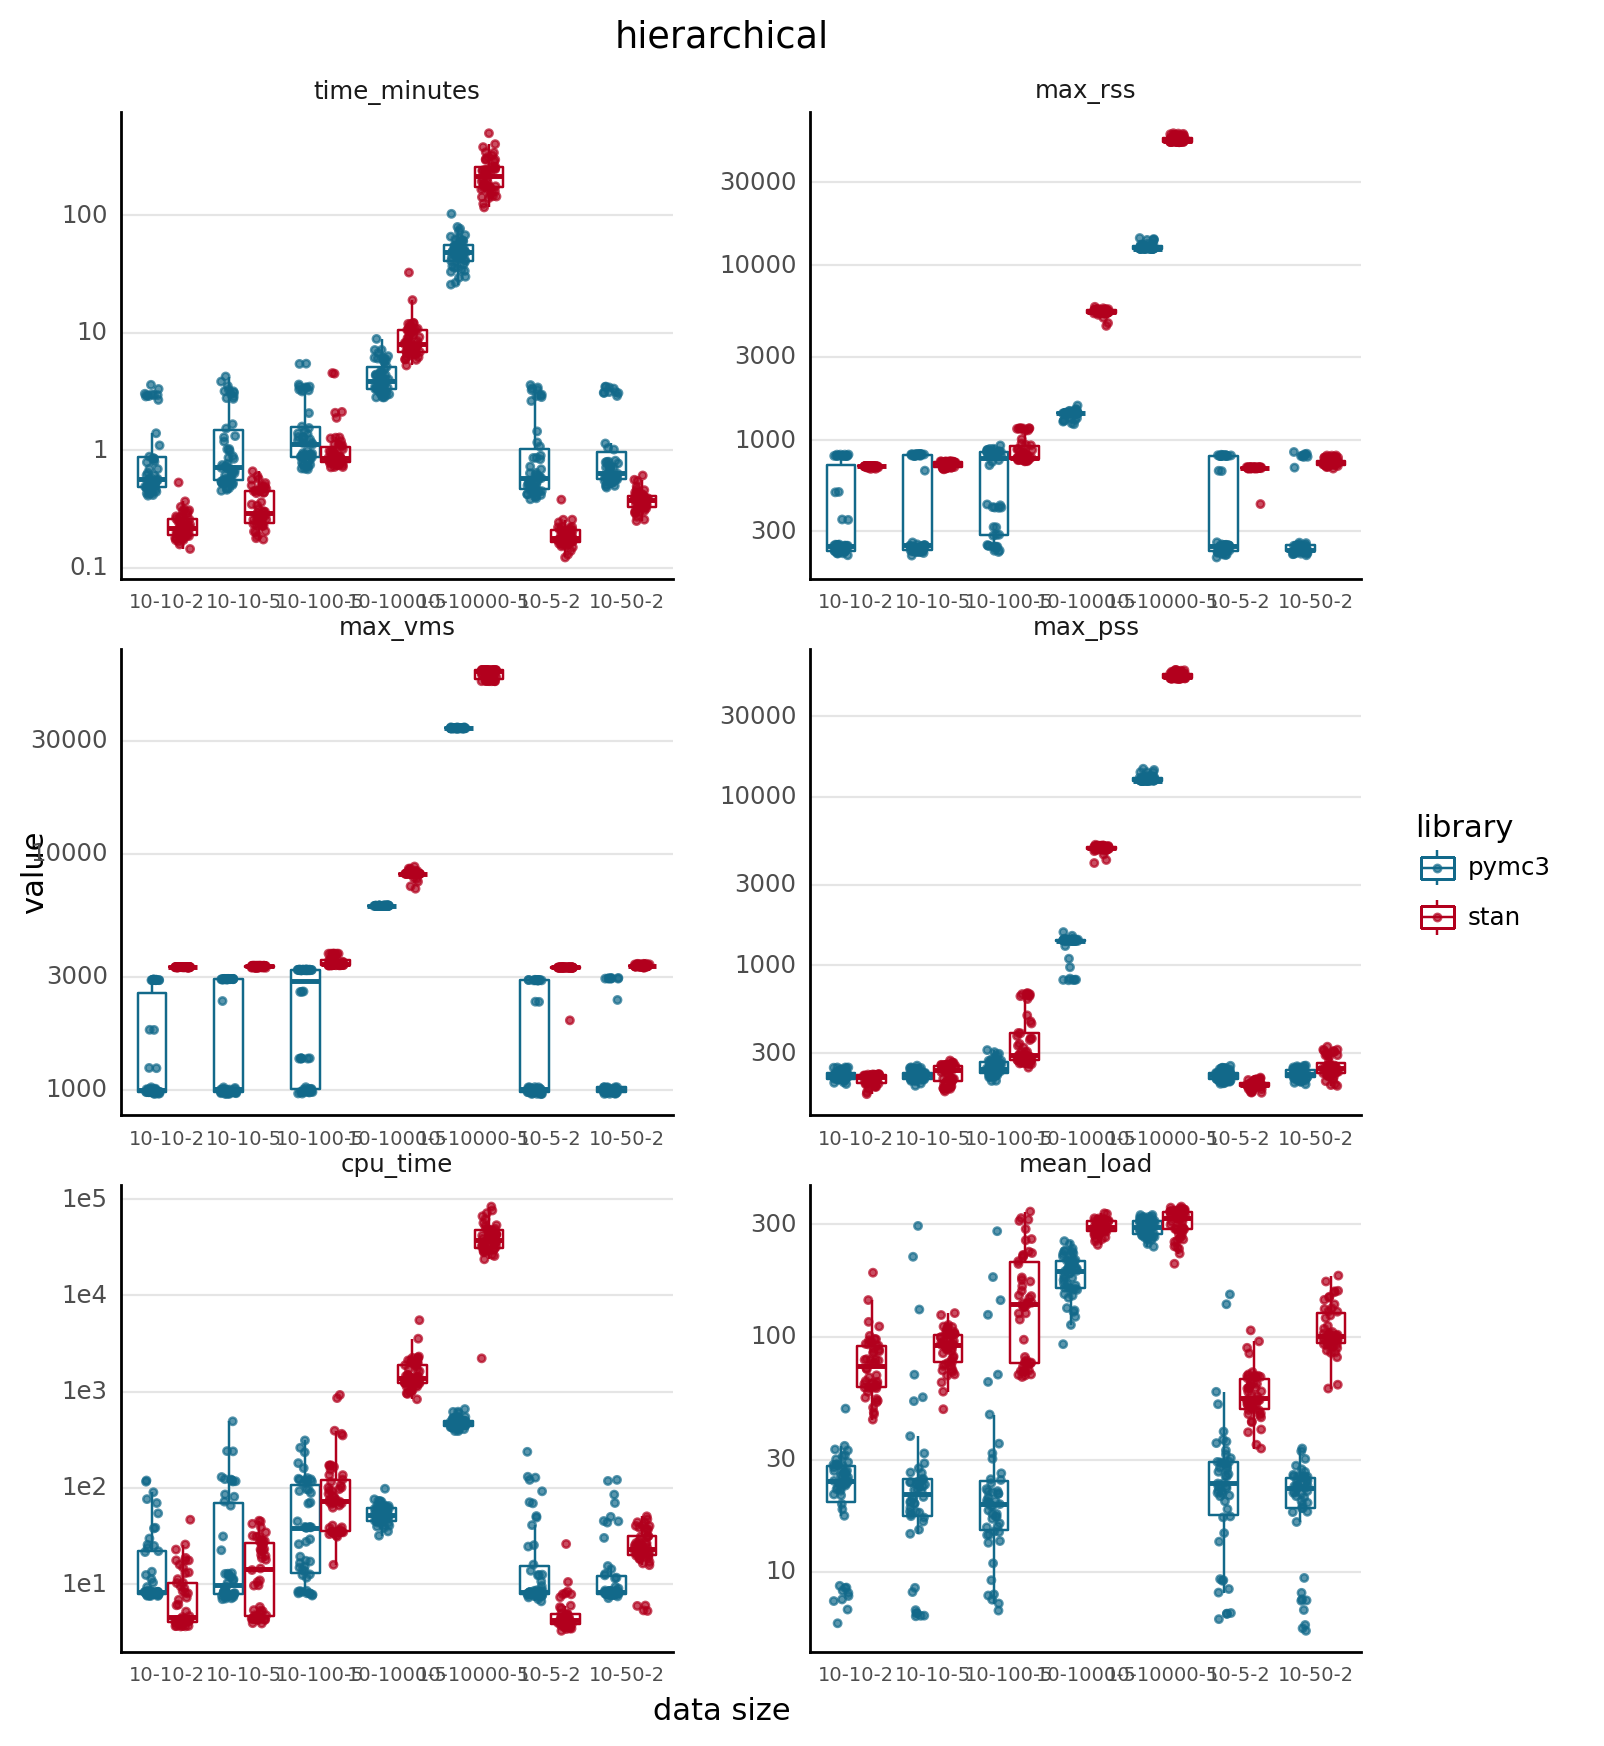

/n/data1/hms/dbmi/park/Cook/pymc3-stan-comparison/.snakemake/conda/1f1b47776dfc6e2c3fc707a52a2e4e7a/lib/python3.9/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 1920 rows containing non-finite values.
/n/data1/hms/dbmi/park/Cook/pymc3-stan-comparison/.snakemake/conda/1f1b47776dfc6e2c3fc707a52a2e4e7a/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_jitter : Removed 1920 rows containing missing values.


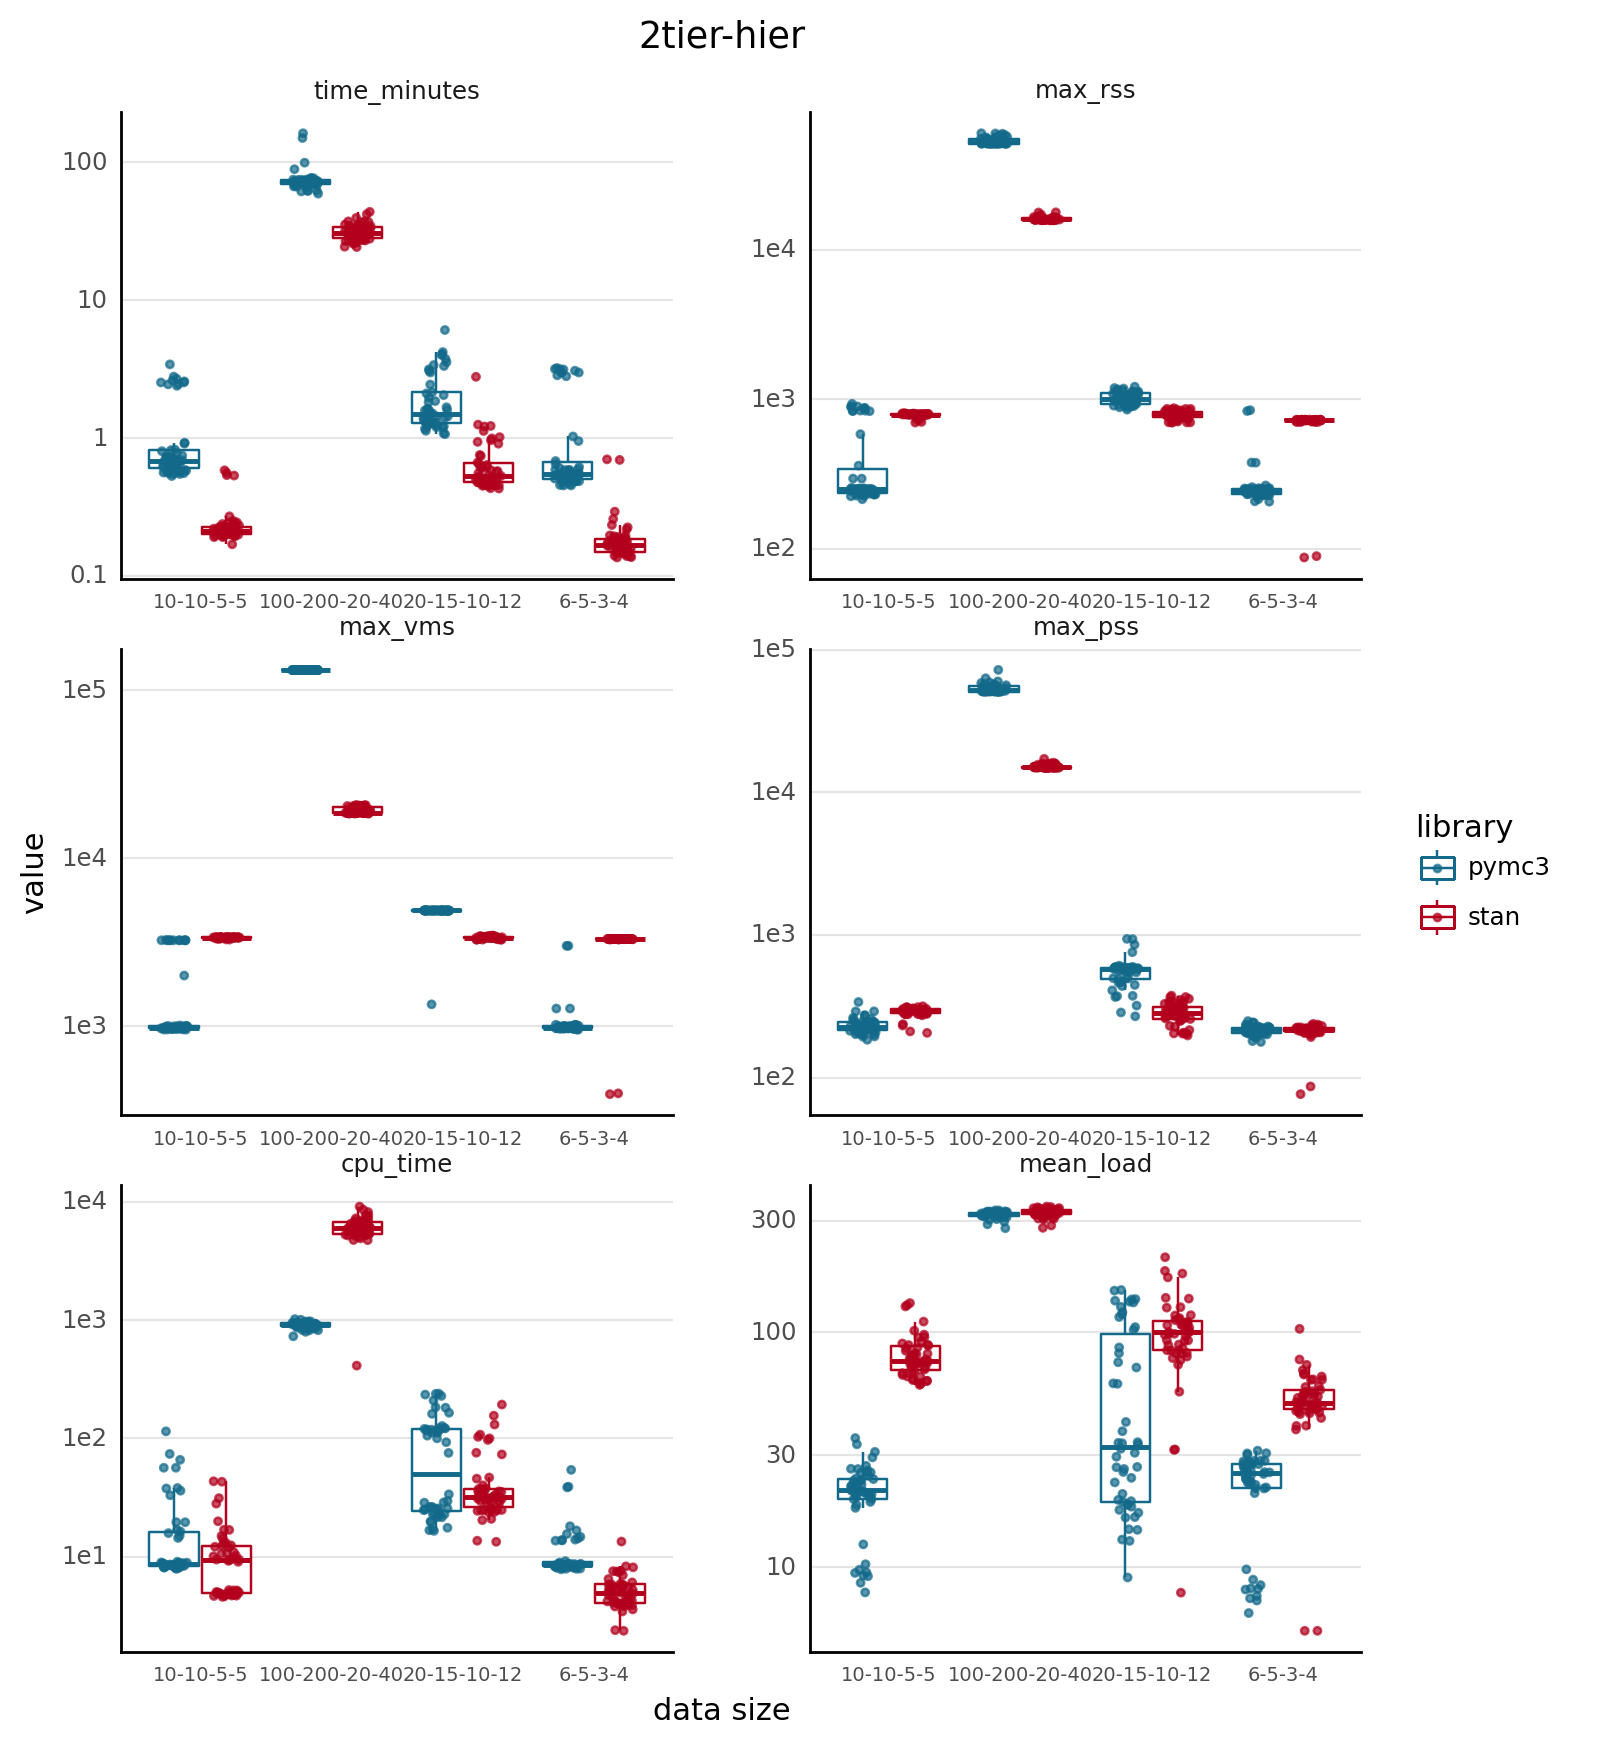

In [6]:
dpos = gg.position_dodge(width=0.8)
jpos = gg.position_jitterdodge(jitter_width=0.2, jitter_height=0, dodge_width=0.8)

for model in benchmarks_long.model.unique():
    print(
        gg.ggplot(
            benchmarks_long.query(f"model == '{model}'"),
            gg.aes(x="factor(data_size)", y="value", color="library"),
        )
        + gg.facet_wrap("variable", scales="free", ncol=2)
        + gg.geom_boxplot(outlier_alpha=0, position=dpos)
        + gg.geom_jitter(size=1, alpha=0.7, position=jpos)
        + gg.scale_y_log10()
        + gg.scale_color_manual(values=library_pal)
        + gg.theme(
            axis_text_x=gg.element_text(size=7),
            subplots_adjust={"wspace": 0.25, "hspace": 0.15},
            figure_size=(8, 10),
        )
        + gg.labs(x="data size", y="value", color="library", title=model)
    )


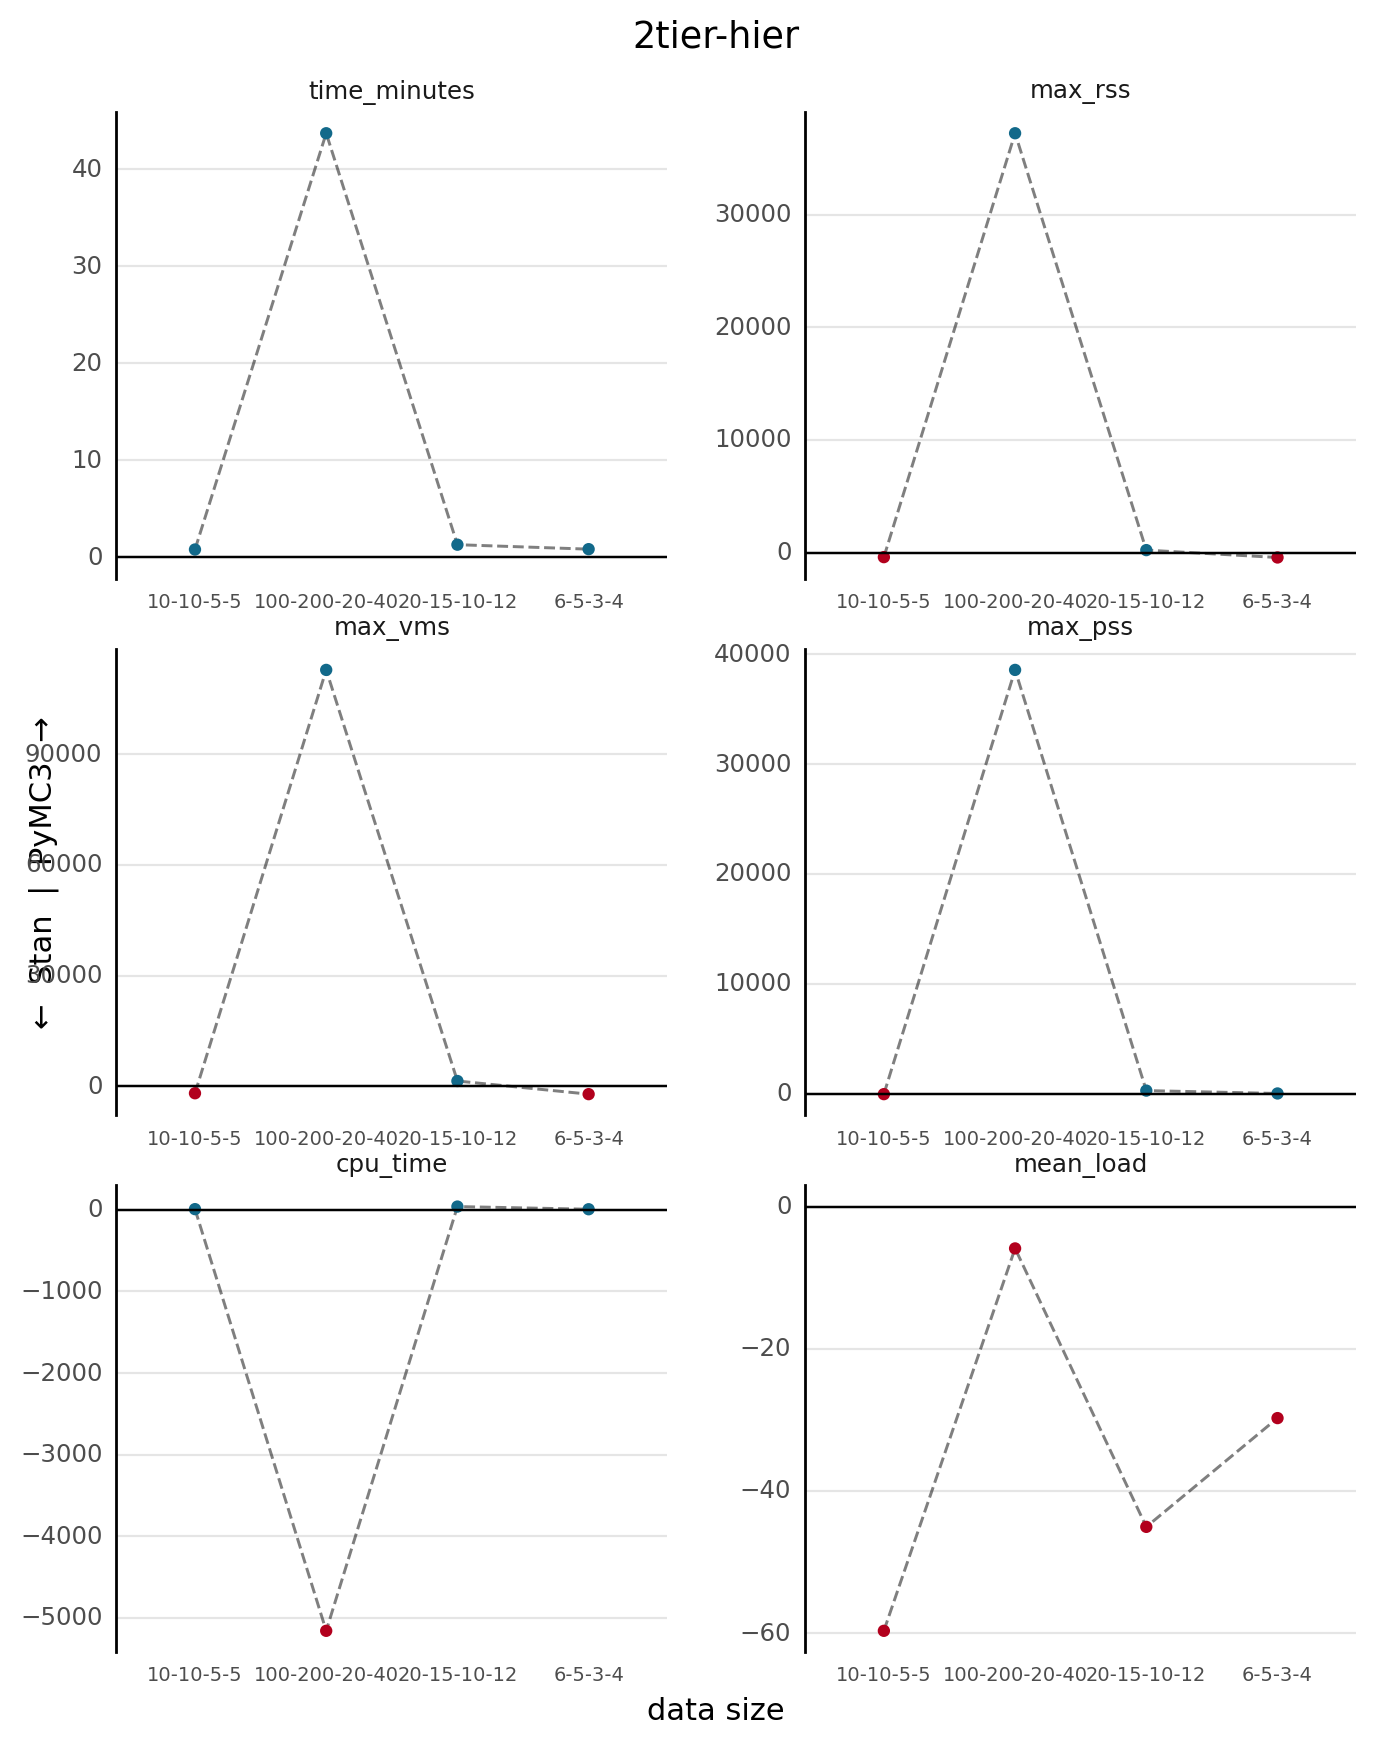

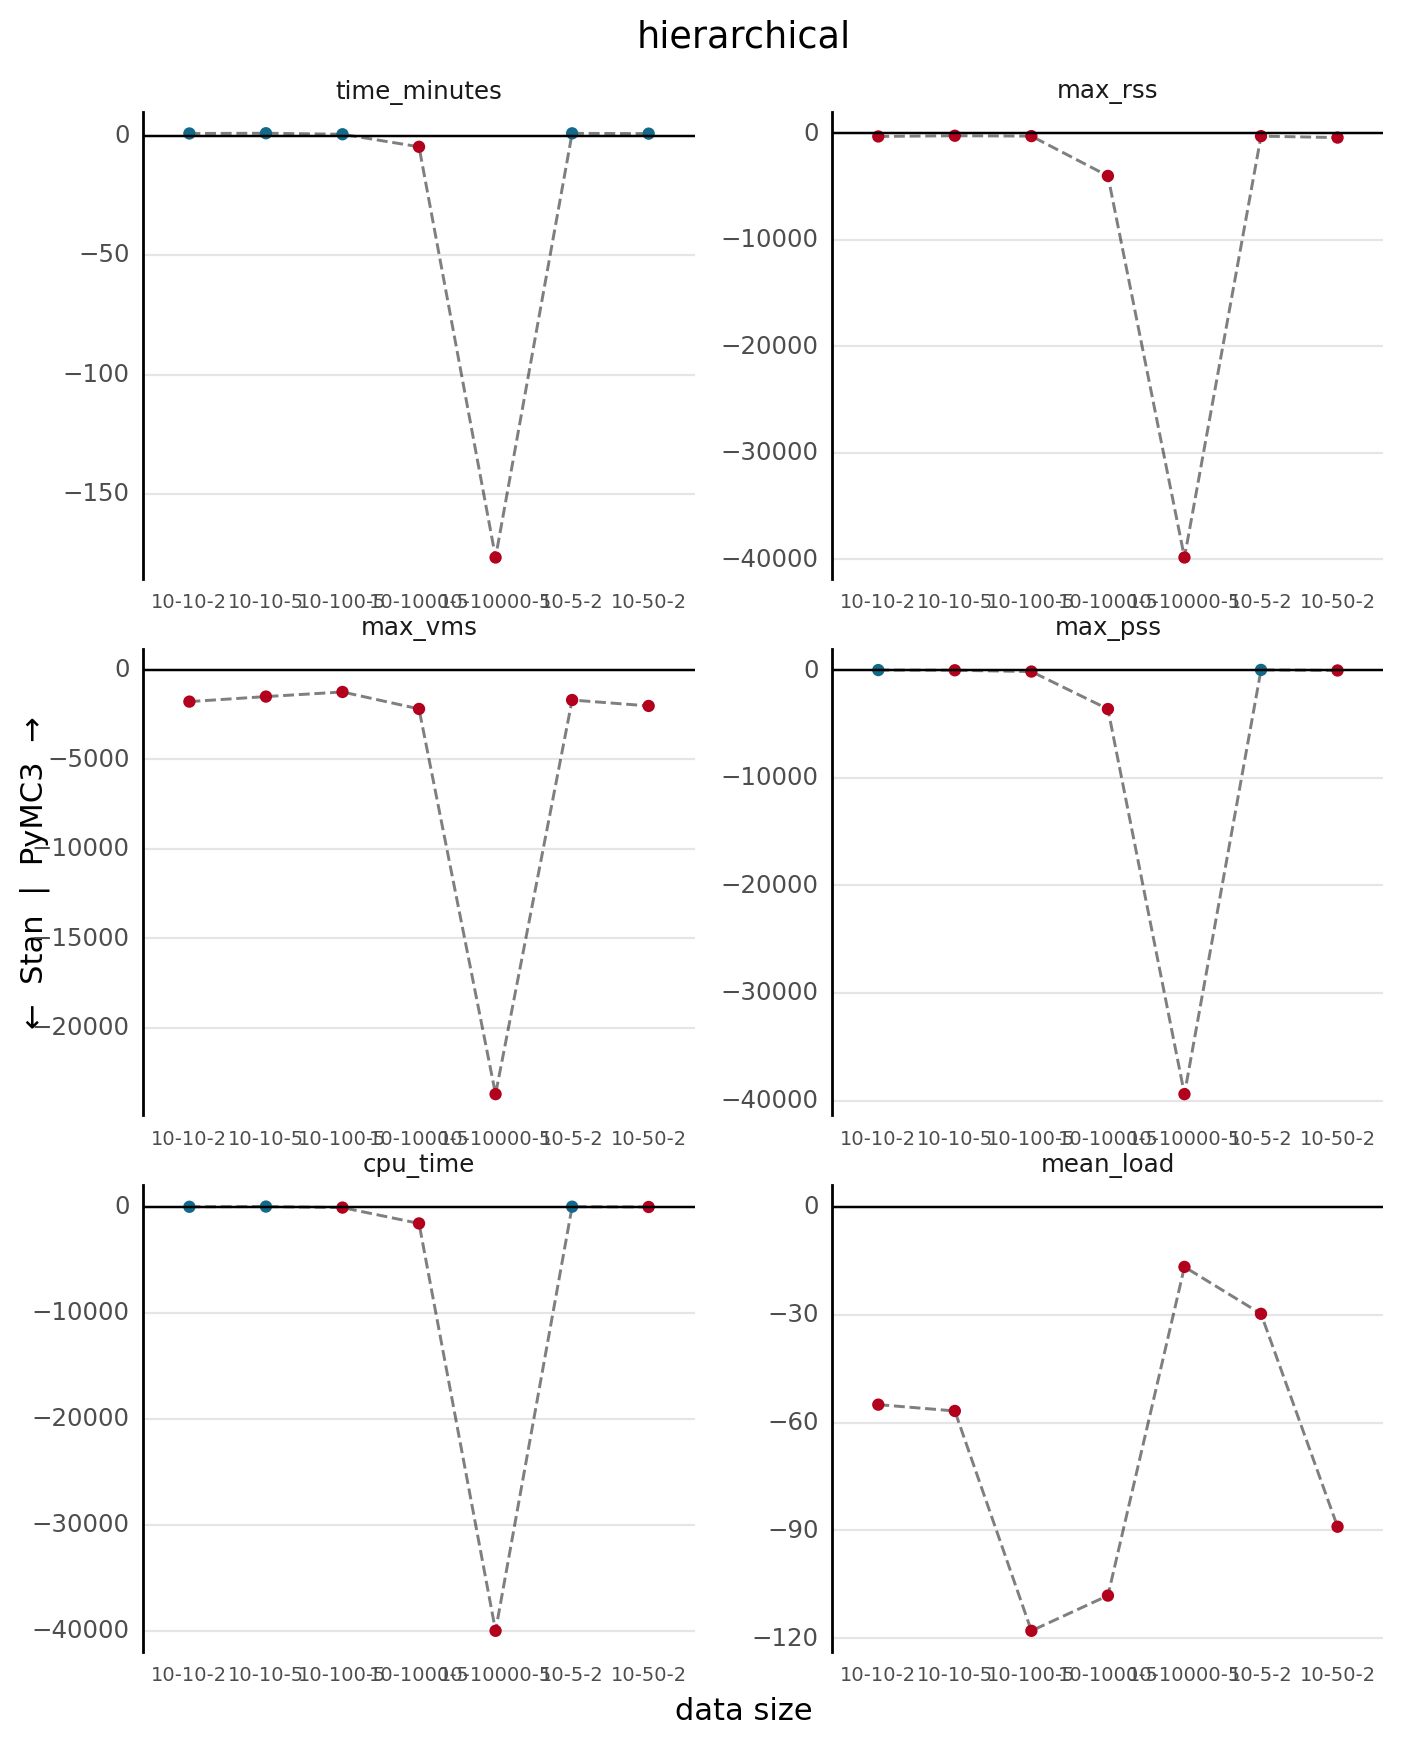

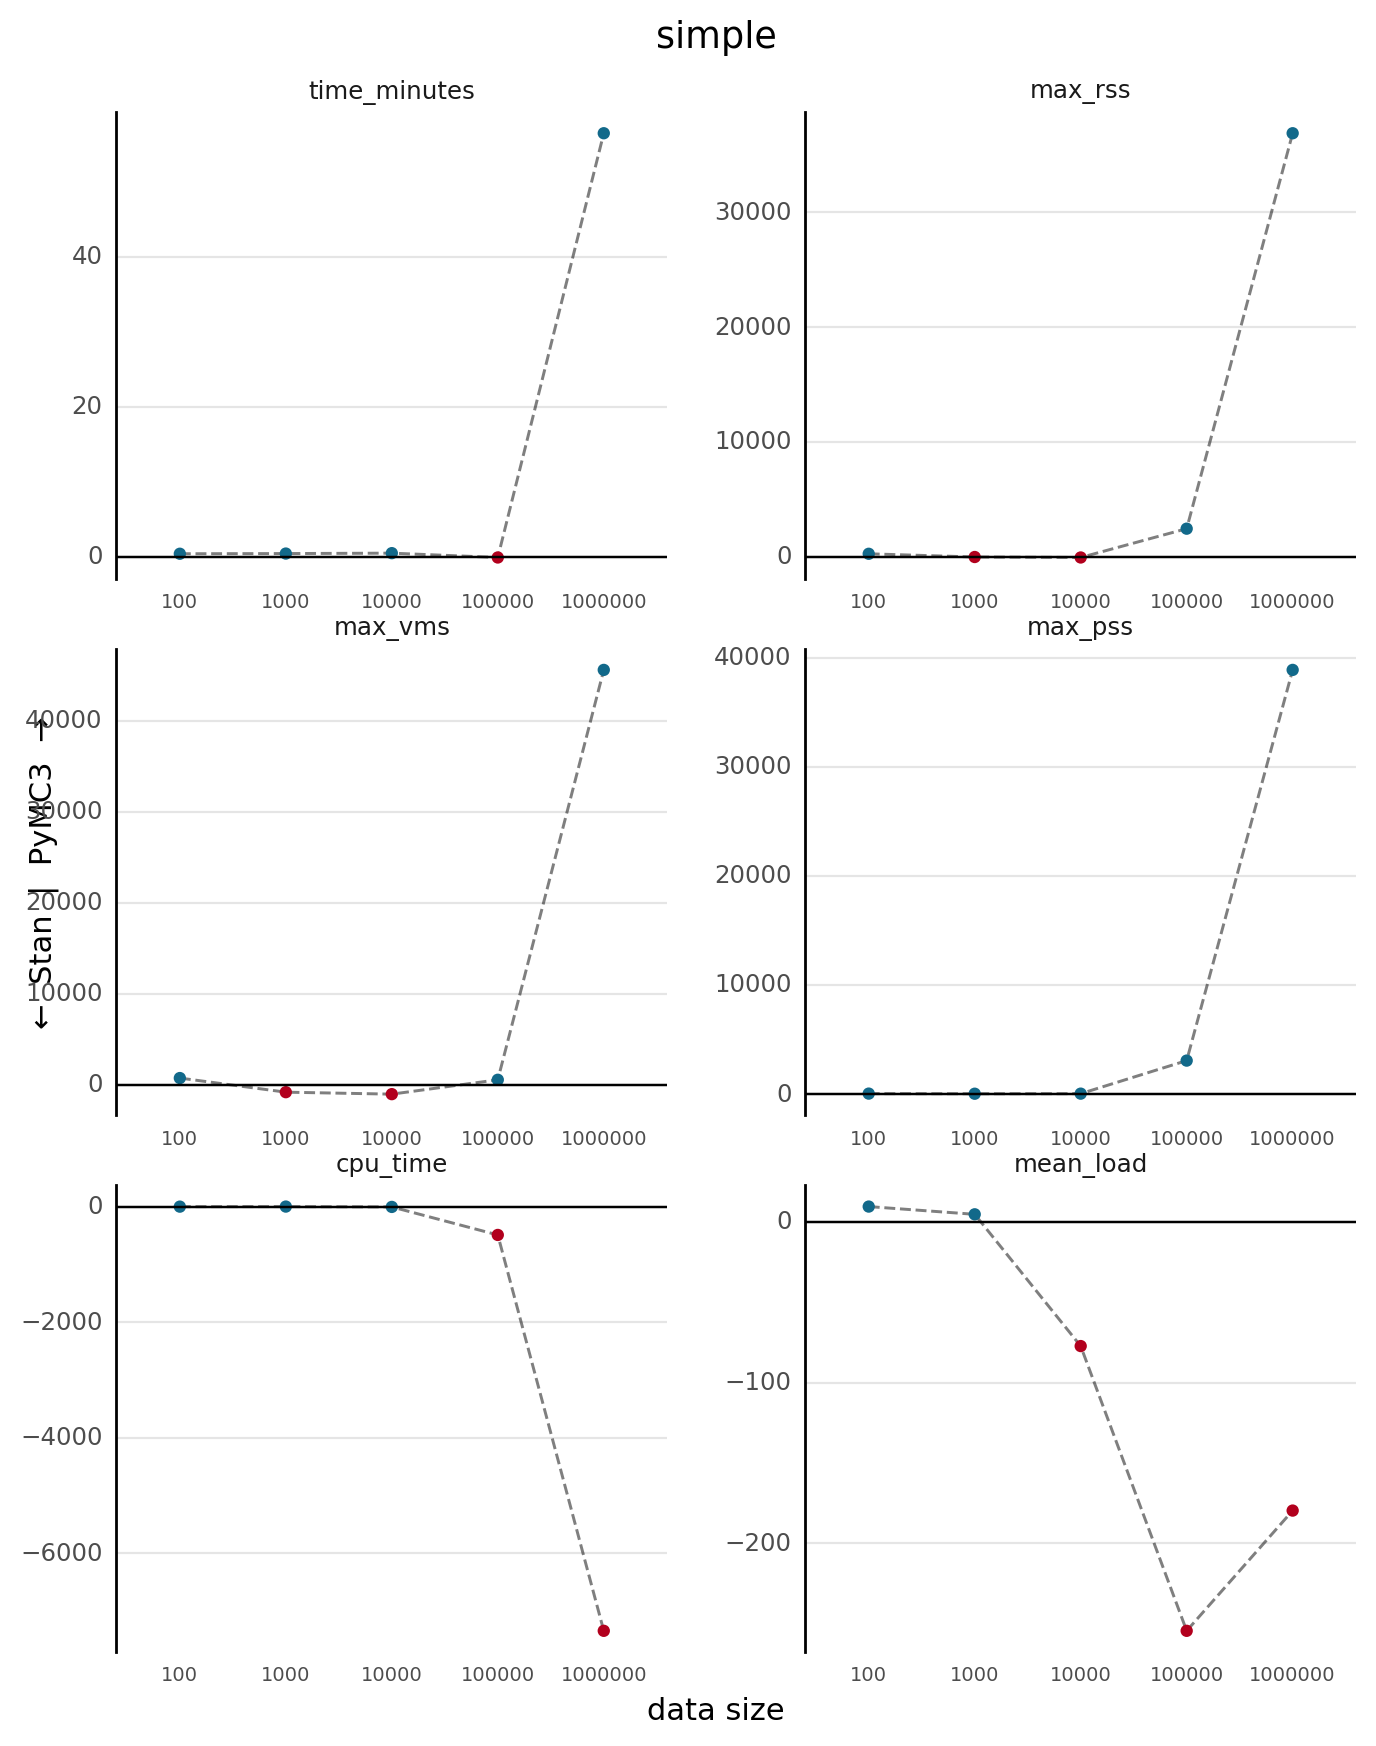

In [7]:
def model_difference(df):
    diff = (
        df[df.library == "pymc3"].value.mean() - df[df.library == "stan"].value.mean()
    )
    return diff


benchmarks_diff = (
    benchmarks_long.groupby(["model", "data_size", "variable"])
    .apply(model_difference)
    .reset_index(drop=False)
    .rename(columns={0: "difference_pymc3_stan"})
)

for model in benchmarks_diff.model.unique():
    _df = benchmarks_diff.query(f"model == '{model}'").assign(
        which_lib=lambda d: [
            "pymc3" if x > 0 else "stan" for x in d.difference_pymc3_stan
        ]
    )
    print(
        gg.ggplot(_df, gg.aes(x="data_size", y="difference_pymc3_stan"))
        + gg.facet_wrap("~variable", scales="free", ncol=2)
        + gg.geom_line(group=1, linetype="--", size=0.6, alpha=0.5)
        + gg.geom_point(gg.aes(color="which_lib"))
        + gg.geom_hline(yintercept=0)
        + gg.scale_color_manual(values=library_pal)
        + gg.theme(
            figure_size=(8, 10),
            axis_text_x=gg.element_text(size=7),
            subplots_adjust={"wspace": 0.25, "hspace": 0.15},
            axis_line_x=gg.element_blank(),
            legend_position="none",
        )
        + gg.labs(title=model, x="data size", y="←  Stan  |  PyMC3  →")
    )


/n/data1/hms/dbmi/park/Cook/pymc3-stan-comparison/.snakemake/conda/1f1b47776dfc6e2c3fc707a52a2e4e7a/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_jitter : Removed 2400 rows containing missing values.


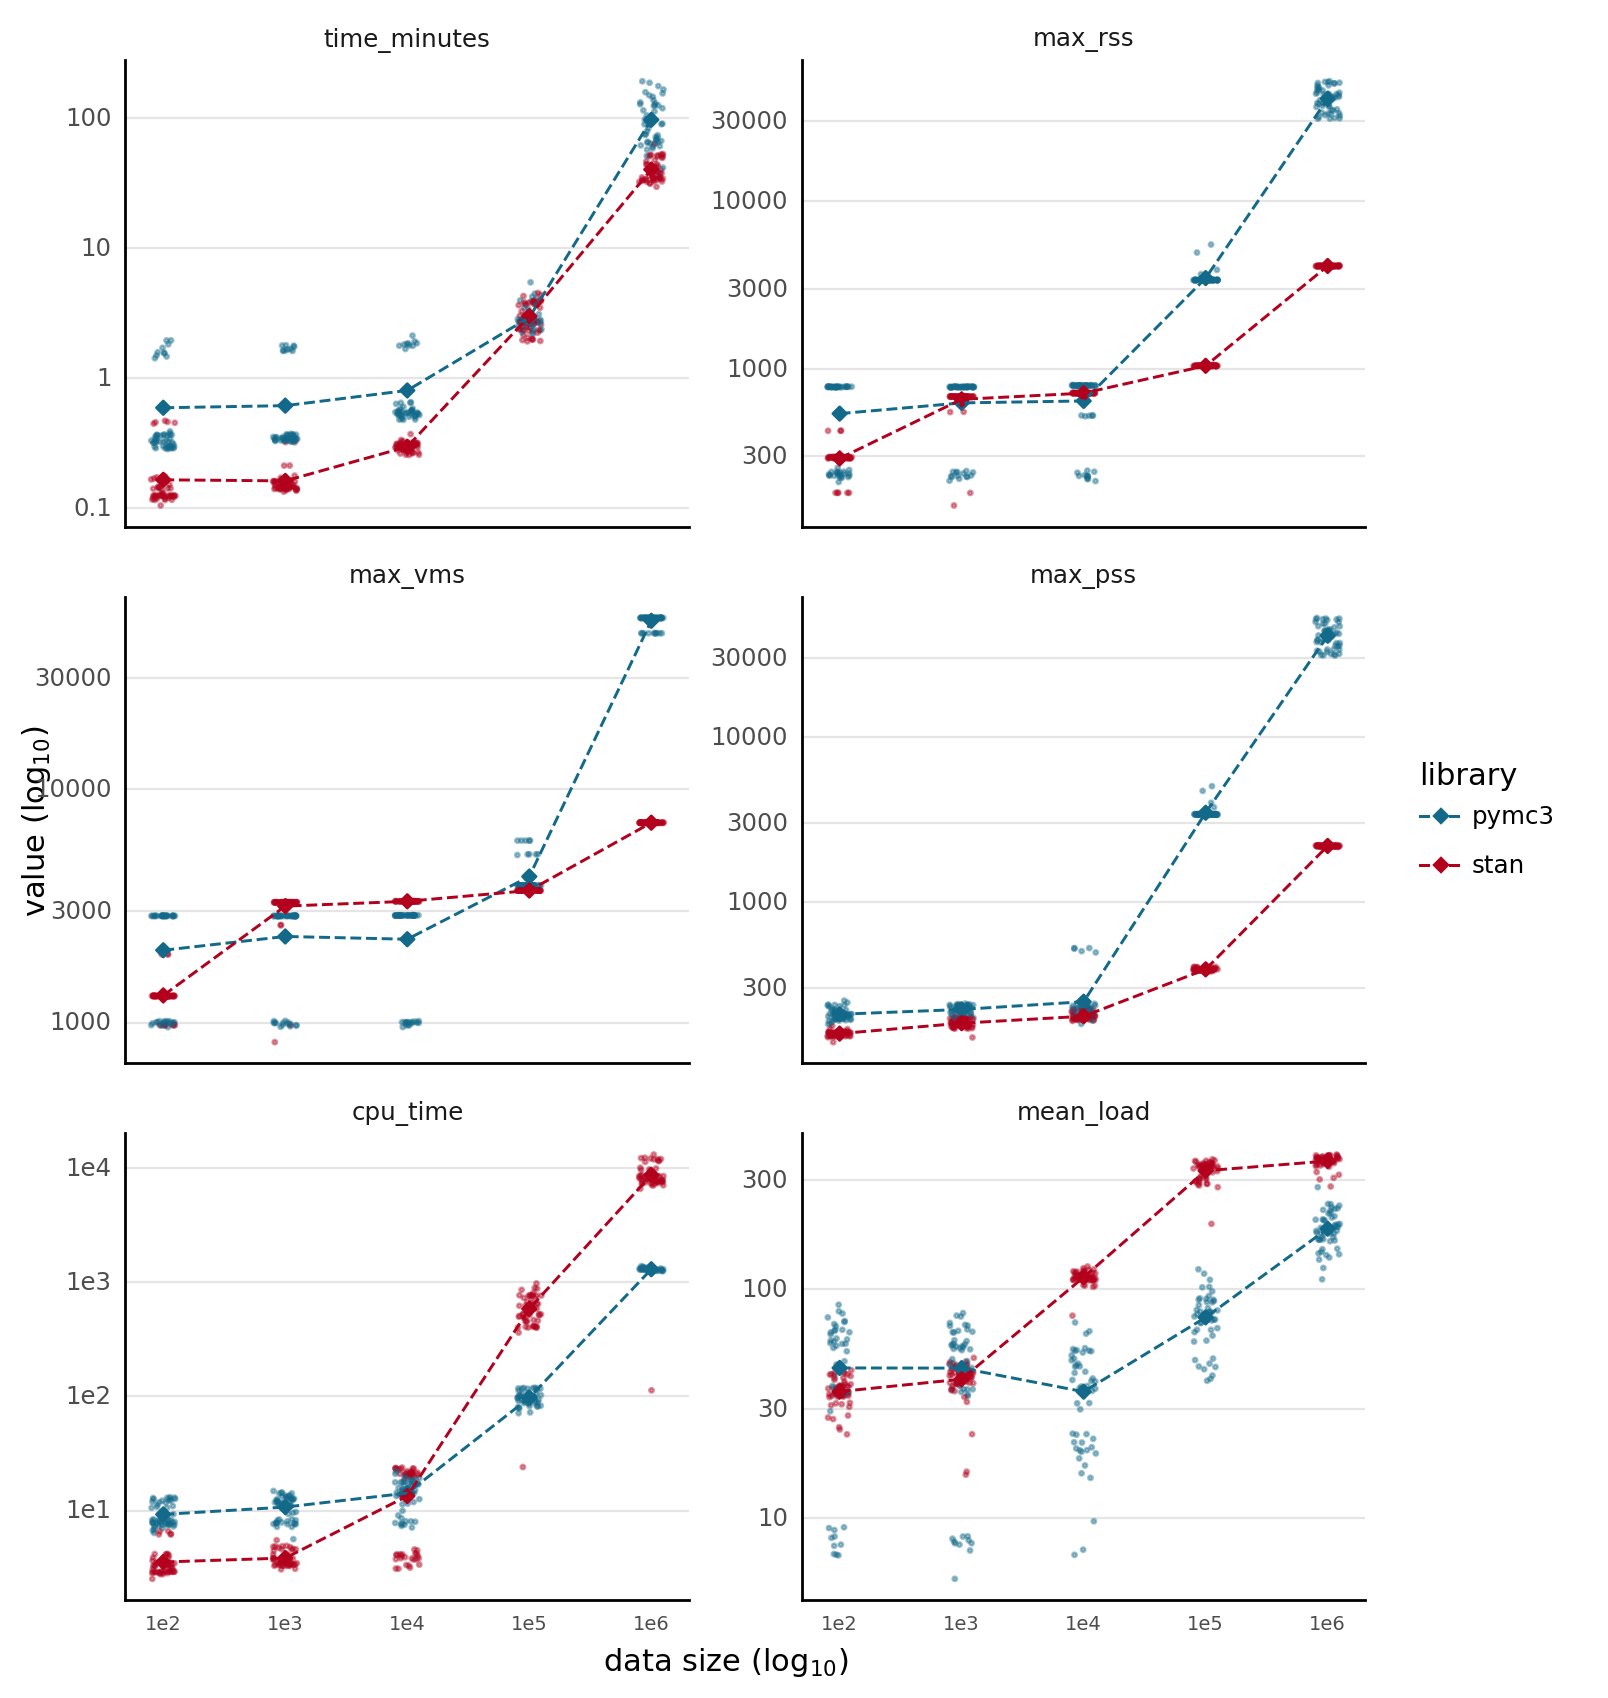

<ggplot: (8732749869572)>

In [8]:
simple_reg_benchmarks = (
    benchmarks_long.copy().query("model == 'simple'").astype({"data_size": int})
)
simple_reg_benchmarks_avg = (
    simple_reg_benchmarks.groupby(["variable", "library", "data_size"])
    .mean()
    .reset_index(drop=False)
)


(
    gg.ggplot(simple_reg_benchmarks, gg.aes(x="data_size", y="value", color="library"))
    + gg.facet_wrap("variable", scales="free_y", ncol=2)
    + gg.geom_jitter(size=0.4, alpha=0.4, width=0.1, height=0)
    + gg.geom_point(data=simple_reg_benchmarks_avg, shape="D", size=1.5)
    + gg.geom_line(data=simple_reg_benchmarks_avg, linetype="--", size=0.6)
    + gg.scale_x_log10()
    + gg.scale_y_log10()
    + gg.scale_color_manual(values=library_pal)
    + gg.theme(
        axis_text_x=gg.element_text(size=7),
        subplots_adjust={"wspace": 0.2, "hspace": 0.15},
        figure_size=(8, 10),
    )
    + gg.labs(x="data size ($\\log_{10}$)", y="value ($\\log_{10}$)", color="library")
)


In [9]:
hierarchical_mdl_bench = (
    benchmarks_long.copy()
    .query("model == 'hierarchical'")
    .reset_index(drop=True)
    .assign(
        n_pts=lambda d: [int(x.split("-")[0]) for x in d.data_size],
        n_groups=lambda d: [int(x.split("-")[1]) for x in d.data_size],
        n_covs=lambda d: [int(x.split("-")[2]) for x in d.data_size],
    )
)

hierarchical_mdl_bench.head()


,name,model,library,data_size,variable,value,n_pts,n_groups,n_covs
0,hierarchical_stan_10-10-2__4,hierarchical,stan,10-10-2,time_minutes,0.301837,10,10,2
1,hierarchical_stan_10-10-2__4,hierarchical,stan,10-10-2,time_minutes,0.192707,10,10,2
2,hierarchical_stan_10-10-2__4,hierarchical,stan,10-10-2,time_minutes,0.177273,10,10,2
3,hierarchical_stan_10-10-2__4,hierarchical,stan,10-10-2,time_minutes,0.312770,10,10,2
4,hierarchical_stan_10-10-2__4,hierarchical,stan,10-10-2,time_minutes,0.185913,10,10,2


/n/data1/hms/dbmi/park/Cook/pymc3-stan-comparison/.snakemake/conda/1f1b47776dfc6e2c3fc707a52a2e4e7a/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_jitter : Removed 320 rows containing missing values.


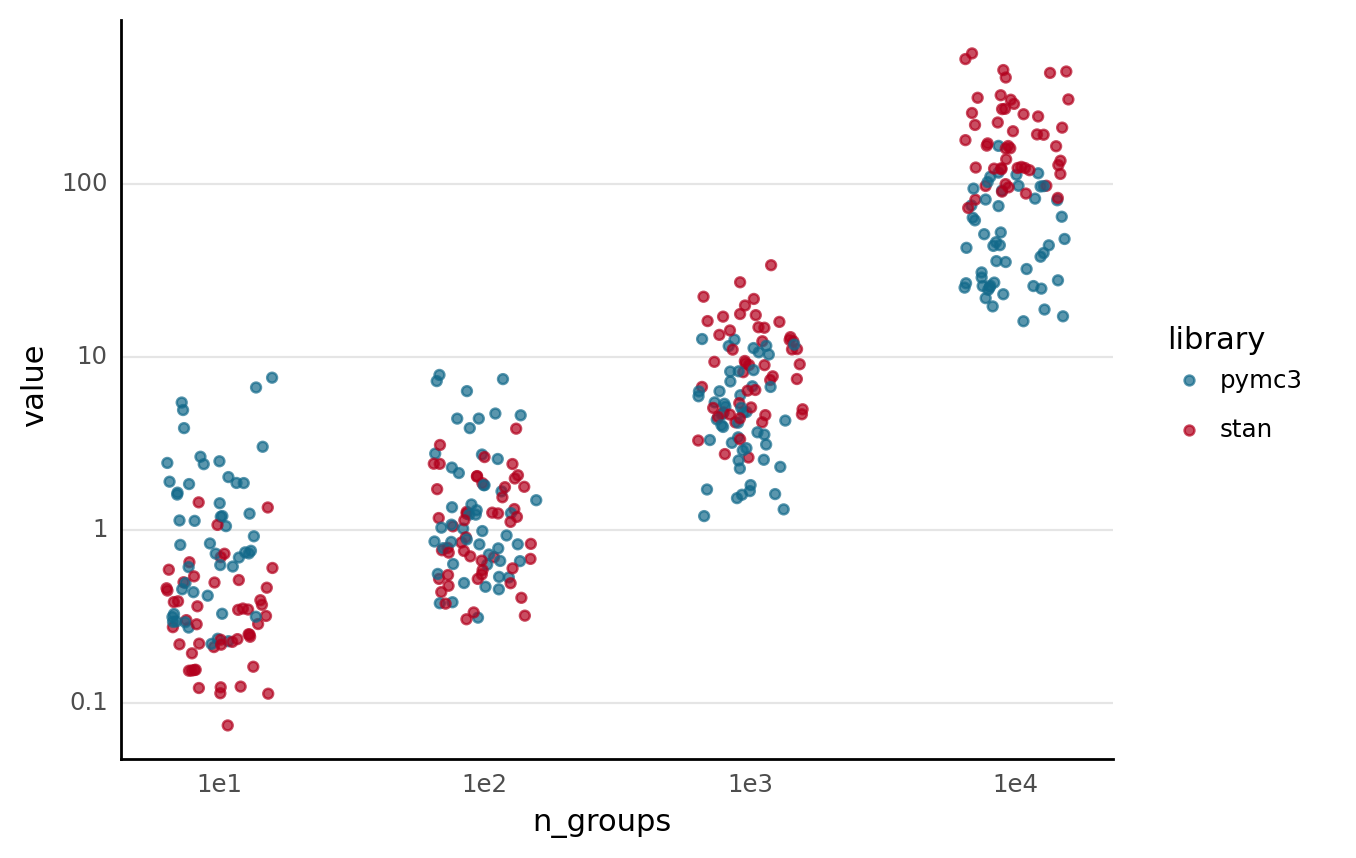

<ggplot: (8732738580869)>

In [10]:
(
    gg.ggplot(hierarchical_mdl_bench.query("variable == 'time_minutes' and n_covs == 5"), gg.aes(x="n_groups", y="value", color="library"))
    + gg.geom_jitter(width=0.2, alpha=0.7)
    + gg.scale_x_log10()
    + gg.scale_y_log10()
    + gg.scale_color_manual(values=library_pal)
)

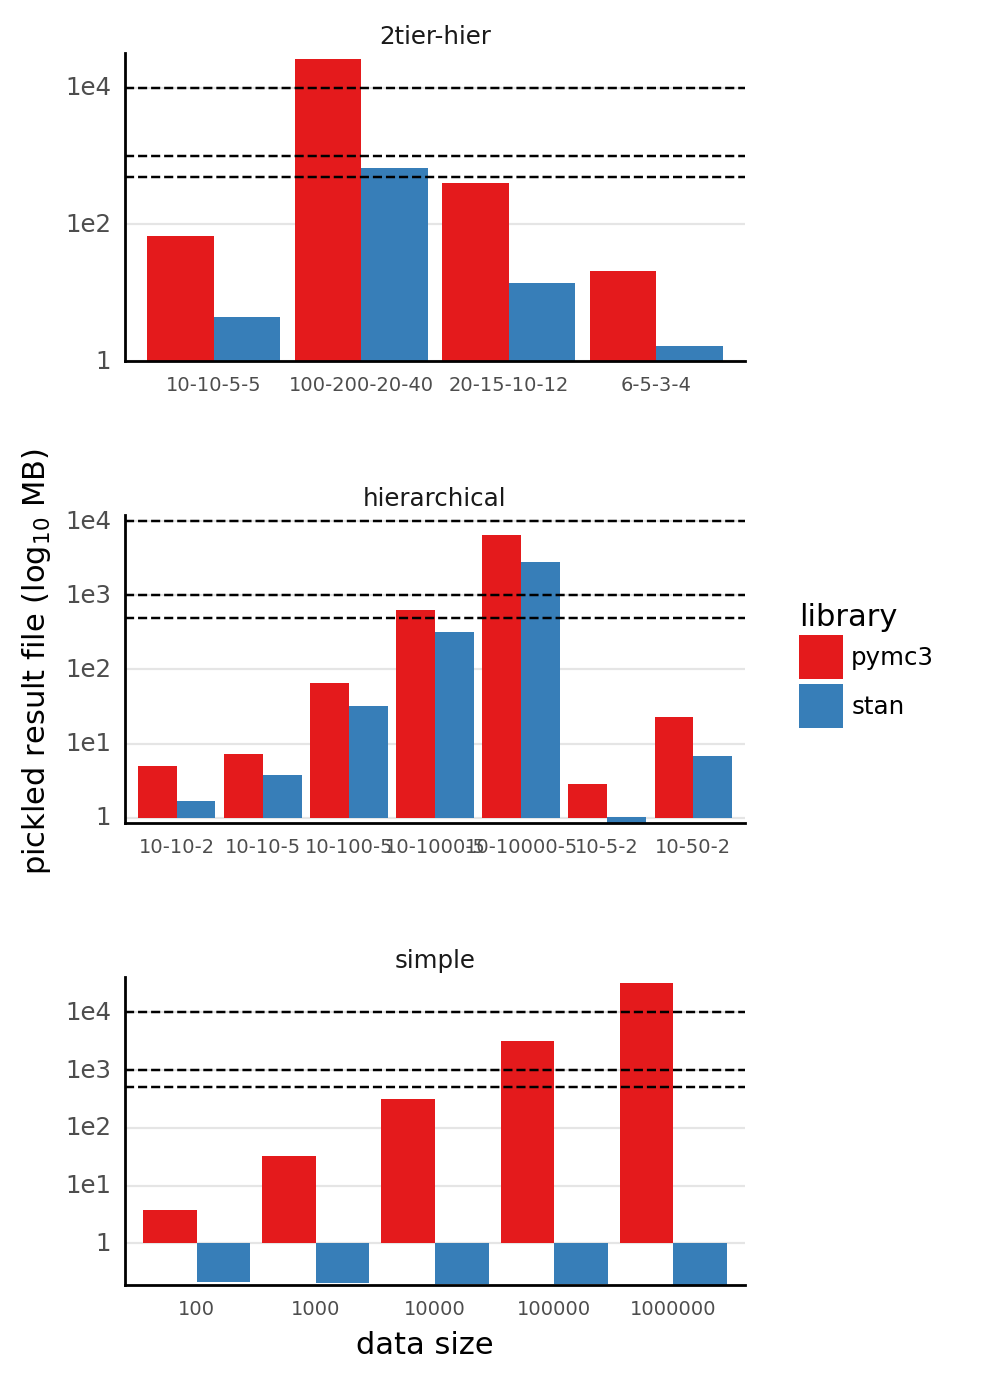

<ggplot: (8732739929594)>

In [11]:
result_file_sizes = pd.read_csv(model_size_csv).pipe(parse_model_names)

breaks: dict[str, float] = {"0.5 GB": 500, "1 GB": 1000, "10 GB": 10000}

(
    gg.ggplot(result_file_sizes, gg.aes(x="data_size", y="mb", fill="library"))
    + gg.facet_wrap("model", ncol=1, scales="free")
    + gg.geom_col(position="dodge")
    + gg.geom_hline(yintercept=breaks.values(), linetype="--", color="black")
    + gg.scale_y_log10(expand=(0, 0, 0.02, 0))
    + gg.scale_fill_brewer(type="qual", palette="Set1")
    + gg.theme(
        panel_grid_major_y=gg.element_line(),
        axis_text_x=gg.element_text(size=7),
        figure_size=(4, 8),
        subplots_adjust={"hspace": 0.5},
    )
    + gg.labs(x="data size", y="pickled result file ($\\log_{10}$ MB)", fill="library")
)


---

In [12]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-12-24

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.30.0

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 3.10.0-1160.45.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-230.o2.rc.hms.harvard.edu

Git branch: custom-benchmarking

pandas  : 1.3.4
re      : 2.2.1
plotnine: 0.8.0
janitor : 0.21.2

